## Tweet Emotion Recognition: NLP with TensorFlow

## Introduction

Welcome to this Jupyter notebook on **tweet emotion recognition** using the **Emotions dataset for NLP** from **Kaggle**. In this notebook, I will explore a dataset of tweets labeled with one of seven emotions: anger, fear, joy, love, sadness and surprise.

The Emotions dataset for NLP is a great resource for anyone interested in building a model for emotion recognition in tweets. It provides a large and diverse set of tweets labeled with their corresponding emotions, making it an ideal dataset for training and testing NLP models.

**This notebook is my introduction to NLP with TensorFlow. I hope that through this project I can build working knowledge on NLP and TensorFlow and deepen my understanding of Neural Networks.**

Throughout this notebook, I will cover the following topics:

- Data exploration
- Data Tokenization
- Data Padding and Truncating
- Model creation and Training
- Model evaluation

By the end of this notebook, you will have a solid understanding of how to use the Emotions dataset for NLP to train a model for tweet emotion recognition and how to evaluate its performance as I will try to document what I'm doing thoughout the process. Let's get started!

## Setup and Imports

1. Installing Hugging Face's nlp package
2. Importing libraries

In [1]:
%pip install nlp

     ---------------------------------------- 1.7/1.7 MB 1.2 MB/s eta 0:00:00
     -------------------------------------- 110.5/110.5 kB 1.1 MB/s eta 0:00:00
     ---------------------------------------- 78.5/78.5 kB 1.1 MB/s eta 0:00:00


In [1]:
%matplotlib inline

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import nlp
import random


def show_history(h):
    epochs_trained = len(h.history['loss'])
    plt.figure(figsize=(16, 6))

    plt.subplot(1, 2, 1)
    plt.plot(range(0, epochs_trained), h.history.get('accuracy'), label='Training')
    plt.plot(range(0, epochs_trained), h.history.get('val_accuracy'), label='Validation')
    plt.ylim([0., 1.])
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(range(0, epochs_trained), h.history.get('loss'), label='Training')
    plt.plot(range(0, epochs_trained), h.history.get('val_loss'), label='Validation')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    
def show_confusion_matrix(y_true, y_pred, classes):
    from sklearn.metrics import confusion_matrix
    
    cm = confusion_matrix(y_true, y_pred, normalize='true')

    plt.figure(figsize=(8, 8))
    sp = plt.subplot(1, 1, 1)
    ctx = sp.matshow(cm)
    plt.xticks(list(range(0, 6)), labels=classes)
    plt.yticks(list(range(0, 6)), labels=classes)
    plt.colorbar(ctx)
    plt.show()

    
print('Using TensorFlow version', tf.__version__)

Using TensorFlow version 2.11.0


## Importing and Undestanding the Data

1. Importing the Tweet Emotion dataset
2. Creating train, validation and test sets
3. Extracting tweets and labels from the examples
4. Getting an overview of the data

In [2]:
# data = nlp.load_dataset('emotion') : connectionerror: couldn't reach https://www.dropbox.com/s/1pzkadrvffbqw6o/train.txt?dl=1
#didn't work! see more : https://github.com/dair-ai/emotion_dataset/issues/5
#so I'll be using https://www.kaggle.com/datasets/praveengovi/emotions-dataset-for-nlp
import pandas as pd

train = pd.read_csv(
    "dataset/train.txt",
    sep=";",
    names=["text","label"])

val = pd.read_csv(
    "dataset/val.txt",
    sep=";",
    names=["text","label"])

test = pd.read_csv(
    "dataset/test.txt",
    sep=";",
    names=["text","label"])

In [3]:
train.head()

,text,label
0,i didnt feel humiliated,sadness
1,i can go from feeling so hopeless to so damned...,sadness
2,im grabbing a minute to post i feel greedy wrong,anger
3,i am ever feeling nostalgic about the fireplac...,love
4,i am feeling grouchy,anger


In [4]:
def get_tweet(data):
    tweets = data["text"]
    labels = data["label"]
    return tweets, labels

In [5]:
tweets, labels = get_tweet(train)
print(tweets[50]," : ", labels[50])

i need to feel the dough to make sure its just perfect  :  joy


In [6]:
def data_description(data):
    shape = data.shape
    text_nulls = data["text"].isnull().sum()
    label_nulls = data["label"].isnull().sum()
    label_count = data["label"].value_counts()
    
    plt.hist(data["label"])
    plt.xlabel('emotions')
    plt.ylabel('Frequency')
    plt.title('data distribution')
    
    print("data shape : ",shape)
    print("null values in text field : ", text_nulls)
    print("null values in text field : ", label_nulls)
    print("label counts")
    print(label_count)
    plt.show()

Training data description
data shape :  (16000, 2)
null values in text field :  0
null values in text field :  0
label counts
joy         5362
sadness     4666
anger       2159
fear        1937
love        1304
surprise     572
Name: label, dtype: int64


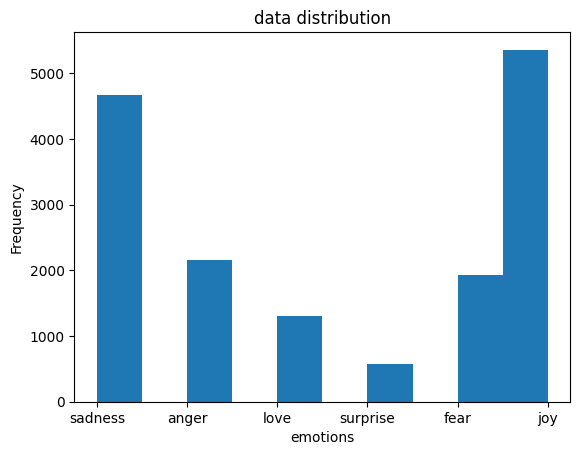

In [7]:
print("Training data description")
data_description(train)

Test data description
data shape :  (2000, 2)
null values in text field :  0
null values in text field :  0
label counts
joy         695
sadness     581
anger       275
fear        224
love        159
surprise     66
Name: label, dtype: int64


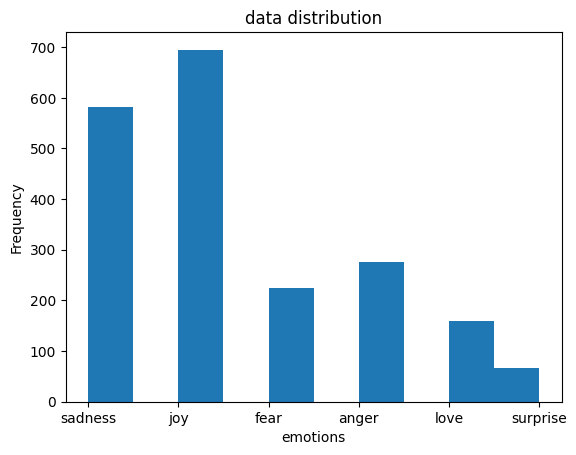

In [9]:
print("Test data description")
data_description(test)

Validation data description
data shape :  (2000, 2)
null values in text field :  0
null values in text field :  0
label counts
joy         704
sadness     550
anger       275
fear        212
love        178
surprise     81
Name: label, dtype: int64


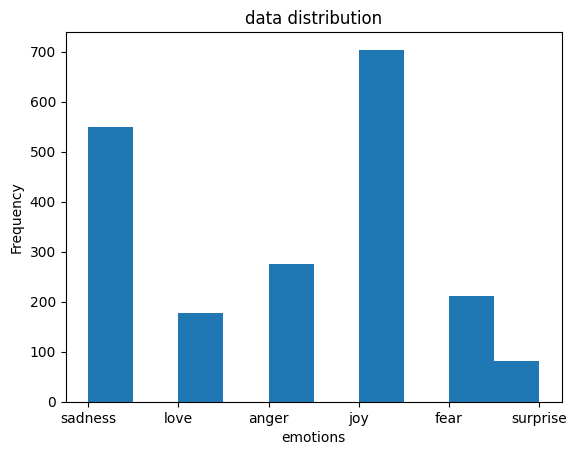

In [10]:
print("Validation data description")
data_description(val)

## Tokenization

Tokenization is the process of breaking down a string of text into smaller pieces, called tokens. These tokens can be words, phrases, or symbols. Tokenization is a common step in natural language processing (NLP) tasks, such as text classification, sentiment analysis, and machine translation.

The `Tokenizer` class in the `tensorflow.keras.preprocessing.text` module in TensorFlow provides a convenient way to perform tokenization on text data. The class can be used to tokenize text into words or characters, and it also provides methods to map the tokens to integers, which can be used as input to neural networks.

1. Tokenizing the tweets

In [11]:
from tensorflow.keras.preprocessing.text import Tokenizer

In [12]:
tokenizer = Tokenizer(num_words=10000, oov_token="<UNK>")
tokenizer.fit_on_texts(tweets)

In [13]:
print(tweets[50])
tokenizer.texts_to_sequences([tweets[50]])

i need to feel the dough to make sure its just perfect


[[2, 105, 5, 3, 6, 7419, 5, 80, 158, 79, 32, 356]]

## Padding and Truncating Sequences

In natural language processing (NLP), it is common to use sequences of words as input for models such as neural networks. However, these sequences often have different lengths, which can cause problems when training and using the model.

By padding or truncating the data to a fixed length, we ensure that all sequences have the same length and the model can process them efficiently and effectively. This is particularly important for models such as recurrent neural networks (RNNs) and convolutional neural networks (CNNs) which have a fixed input shape.


1. Checking length of the tweets
2. Creating padded sequences

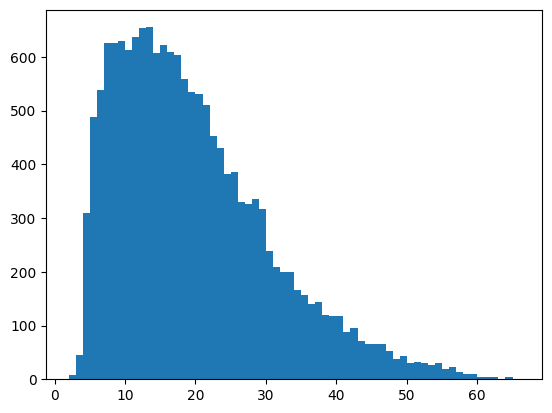

In [14]:
lengths = [len(s.split()) for s in tweets]
plt.hist(lengths, bins=len(set(lengths)))
plt.show()

In [15]:
# We notice that most of the tweets have less than 50 words
maxlen = 50

from tensorflow.keras.preprocessing.sequence import pad_sequences

In [16]:
# we need to pad or truncate the sequences to a fixed length, specified by the variable "maxlen".
# This is to ensure that all sequences have the same length, which is necessary for some models to work.
def get_sequences(tokenizer, tweets):
    sequences = tokenizer.texts_to_sequences(tweets)
    padded_sequences = pad_sequences(sequences, truncating='post', padding='post', maxlen=maxlen)
    return padded_sequences

In [17]:
padded_train_sequences = get_sequences(tokenizer, tweets)

In [18]:
padded_train_sequences[50]

array([   2,  105,    5,    3,    6, 7419,    5,   80,  158,   79,   32,
        356,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0])

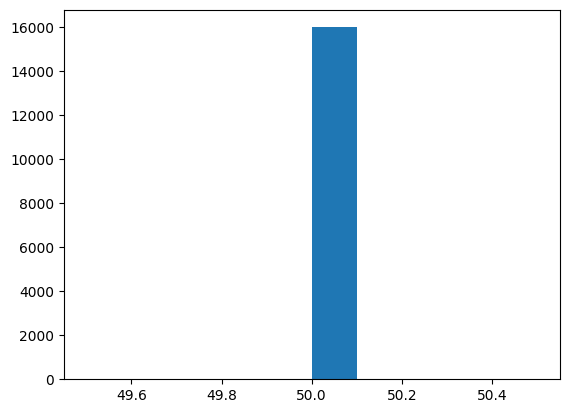

In [19]:
lengths = [len(l) for l in padded_train_sequences]
plt.hist(lengths)
plt.show()

## Preparing the Labels

1. Creating classes to index and index to classes dictionaries
2. Converting text labels to numeric labels

In [20]:
classes = set(labels)
classes

{'anger', 'fear', 'joy', 'love', 'sadness', 'surprise'}

In [21]:
class_to_index = dict((c,i) for i, c in enumerate(classes))
index_to_class = dict((value,key) for key, value in class_to_index.items())

In [22]:
class_to_index

{'anger': 0, 'love': 1, 'joy': 2, 'fear': 3, 'surprise': 4, 'sadness': 5}

In [23]:
index_to_class

{0: 'anger', 1: 'love', 2: 'joy', 3: 'fear', 4: 'surprise', 5: 'sadness'}

In [24]:
labels_to_ids = lambda labels : np.array([class_to_index.get(x) for x in labels])

In [25]:
ids_to_labels = lambda ids : np.array([index_to_class.get(x) for x in ids])

In [26]:
train_labels = labels_to_ids(labels)
train_labels[50]

2

## Creating the Model

1. Creating the model
2. Compiling the model

In [27]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(10000, 16, input_length=maxlen),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20)),
    tf.keras.layers.Dense(6, activation='softmax')
])
model.compile(
    loss = 'sparse_categorical_crossentropy',
    optimizer = 'adam',
    metrics = ['accuracy']
)

In [28]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 50, 16)            160000    
                                                                 
 bidirectional (Bidirectiona  (None, 50, 40)           5920      
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 40)               9760      
 nal)                                                            
                                                                 
 dense (Dense)               (None, 6)                 246       
                                                                 
Total params: 175,926
Trainable params: 175,926
Non-trainable params: 0
_________________________________________________________________


## Training the Model

1. Preparing a validation set
2. Training the model

In [29]:
val_tweets, val_labels = get_tweet(val)
val_sequences = get_sequences(tokenizer, val_tweets)
val_labels = labels_to_ids(val_labels)

In [30]:
val_tweets[69], val_labels[69]

('i have no extra money im worried all of the time and i feel so beyond pathetic',
 5)

In [31]:
m = model.fit(
    padded_train_sequences,
    train_labels,
    validation_data=(val_sequences, val_labels),
    epochs=20,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience = 2)
    ]
)

Epoch 1/20
500/500 [==============================] - 23s 36ms/step - loss: 1.2868 - accuracy: 0.4938 - val_loss: 0.8047 - val_accuracy: 0.7160
Epoch 2/20
500/500 [==============================] - 16s 33ms/step - loss: 0.5477 - accuracy: 0.8071 - val_loss: 0.5517 - val_accuracy: 0.8130
Epoch 3/20
500/500 [==============================] - 13s 26ms/step - loss: 0.3265 - accuracy: 0.8909 - val_loss: 0.4795 - val_accuracy: 0.8395
Epoch 4/20
500/500 [==============================] - 13s 25ms/step - loss: 0.2348 - accuracy: 0.9211 - val_loss: 0.4625 - val_accuracy: 0.8565
Epoch 5/20
500/500 [==============================] - 13s 25ms/step - loss: 0.1675 - accuracy: 0.9474 - val_loss: 0.4304 - val_accuracy: 0.8700
Epoch 6/20
500/500 [==============================] - 12s 25ms/step - loss: 0.1247 - accuracy: 0.9615 - val_loss: 0.3884 - val_accuracy: 0.8855
Epoch 7/20
500/500 [==============================] - 13s 25ms/step - loss: 0.0958 - accuracy: 0.9703 - val_loss: 0.4057 - val_accuracy:

## Evaluating the Model

1. Visualizing training history
2. Prepraring a test set
3. A look at individual predictions on the test set
4. A look at all predictions on the test set

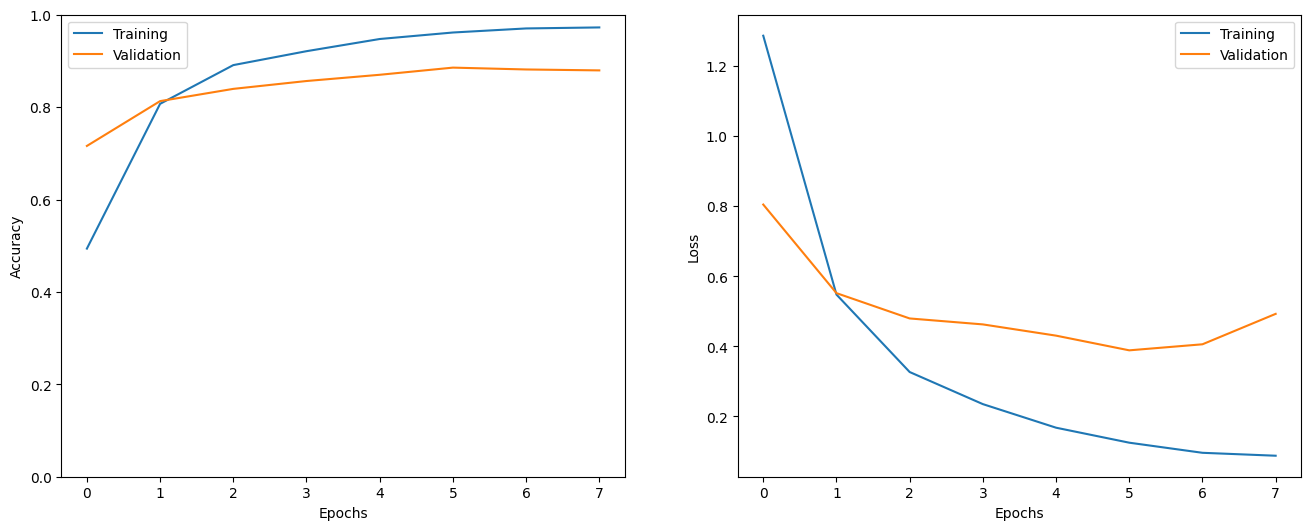

In [32]:
show_history(m)

In [33]:
test_tweets, test_labels = get_tweet(test)
test_sequences = get_sequences(tokenizer, test_tweets)
test_labels = labels_to_ids(test_labels)

In [34]:
_ = model.evaluate(test_sequences, test_labels)

63/63 [==============================] - 1s 10ms/step - loss: 0.4402 - accuracy: 0.8890


In [35]:
for _ in range(5):
    i = random.randint(0, len(test_labels)-1)
    print("Tweet : ", test_tweets[i]," ==> label : ",index_to_class[test_labels[i]])
    p = model.predict(np.expand_dims(test_sequences[i], axis=0))[0]
    pred_class = index_to_class[np.argmax(p).astype('uint8')]
    print("predicted label : ", pred_class)
    print("-----------------------")

Tweet :  i feel like a moronic bastard  ==> label :  sadness
1/1 [==============================] - 2s 2s/step
predicted label :  sadness
-----------------------
Tweet :  i knowing that to this day still makes her feel not shy  ==> label :  fear
1/1 [==============================] - 0s 34ms/step
predicted label :  fear
-----------------------
Tweet :  i try my best to love on them shed some light but i feel deeply compassionate with their problems and hurt even if its someone in the media  ==> label :  love
1/1 [==============================] - 0s 36ms/step
predicted label :  love
-----------------------
Tweet :  i start to feel a little overwhelmed knowing i have to make still  ==> label :  surprise
1/1 [==============================] - 0s 37ms/step
predicted label :  surprise
-----------------------
Tweet :  i never feel like anythings getting resolved with my counseling so i just drift away  ==> label :  joy
1/1 [==============================] - 0s 36ms/step
predicted label :  j

In [42]:
# predictions = model.predict_classes(test_sequences)
predict_x=model.predict(test_sequences) 
classes_x=np.argmax(predict_x,axis=1)

63/63 [==============================] - 1s 9ms/step


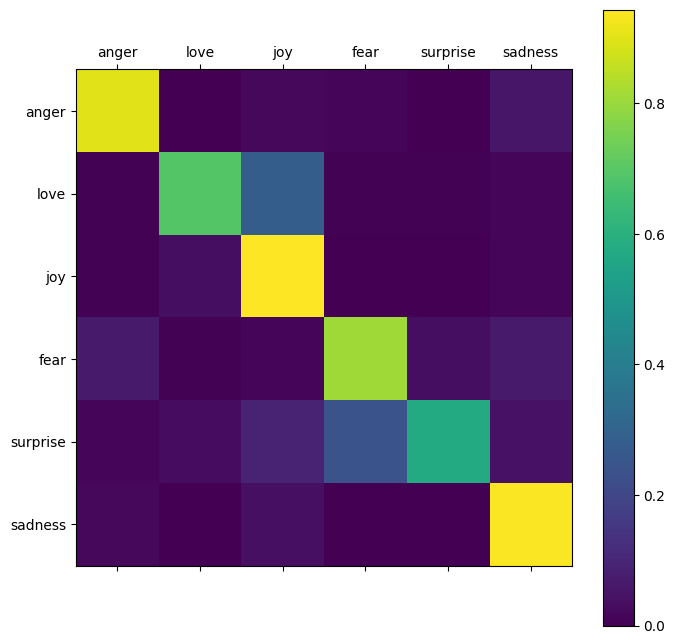

In [43]:
show_confusion_matrix(test_labels, classes_x, list(classes))

## comment on the confusion matrix
the model does a pretty decent job, the predictions are generally correct except the most common misclassifications seem to be between joy-love and fear-surprise. Its possible that this is due to **class inbalance**.
**Class imbalance** occurs when the number of samples in one or more classes (surprise, love, fear and anger) of a dataset is significantly lower than the number of samples in other classes (sadness and joy). This can have a significant impact on the confusion matrix of a model's predictions, as the model may have a tendency to predict the majority class more often, resulting in a higher number of true positives and a lower number of false negatives for that class.

This can lead to a confusion matrix that appears to have good performance metrics, such as high accuracy and precision, but may not be representative of the model's true performance. For example, the precision of the minority class may be lower than expected, and the recall of the minority class may also be lower than expected.
Additionally, it can also lead to an increase in false positives for the majority class.

In order to mitigate the effects of class imbalance, there are several techniques that can be applied, such as **oversampling** the minority class, **undersampling** the majority class, and **adjusting** the class weights during training.